# Uczenie maszynowe: Lab3

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import GradientBoostingClassifier
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import load_digits

### Analiza modelu klasyfikacyjnego
* wziąć konkretne dane, podzielić na część treningową i testową lub uczyć wg. schematu walidacji
krzyżowej
* sprawdzić jakie są hiperparametry danego modelu i znaleźć optymalne
* uczyć parametry modelu z danych, po skończonej nauce je wypisać

In [4]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

data = load_digits()

X = data.data 
y = data.target 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # test_size -> 80% training and 20% test
# random_state = 42 (służy jako ziarne losowości, aby wyniki były powtarzalne), natomiast jak wartość jest ta sama za każdym razem
# to mamy ten sam podział

print ("\nX_test = ", X_test.shape)
print ("Y_test = ", y_test.shape,)
print ("X_train = ", X_train.shape)
print ("Y_train = ", y_train.shape)

# Walidacja krzyżowa k - fold
# Dzielimy na k równych podzbiorów (w których każdy z podzbiorów raz występuje jako zbiór uczący, a pozostała, połączona 
# część zbioru jest wykorzystywana jako zbiór testowy)

k = 5
cv = StratifiedKFold(n_splits=k) # -> schemat walidacji krzyżowej


X_test =  (360, 64)
Y_test =  (360,)
X_train =  (1437, 64)
Y_train =  (1437,)


In [5]:
def evaluate_model(X_train, X_test, Y_train, Y_test, model, param_grid, cv):
    cross_val_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy') # metryka oceny -> dokładność

    # Walidacja krzyżowa - technika trenowania i testowania modelu na różnych podzbiorach danych
    # Dostajemy procentowo jak dobrze model działa tzn jaka jest dokładność
    # na danym podzbiorze danych
    print("\nWyniki walidacji krzyżowej: \n", cross_val_scores)
    print("Średni wynik walidacji krzyżowej: ", cross_val_scores.mean()) 

    # Grid Search -> wyszukanie najlepszych hiperparametrów
    # param grid -> określamy jakie hiperparametry chcemy przetestować
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, Y_train)

    # Najlepsze hiperparametry
    best_params = grid_search.best_params_
    print(f"Najlepsze hiperparametry: {best_params}")

    # Trenowanie modelu z najlepszymi hiperparametrami
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, Y_train)

    # Predykcje i ocena na zbiorze testowym
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Dokładność na zbiorze testowym: {accuracy:.4f}")
    print("Raport klasyfikacji:\n", classification_report(y_test, y_pred, zero_division=0))

    # Wypisanie końcowych parametrów modelu
    print("Końcowe parametry modelu:")
    print(best_model.get_params())

### 1. Naiwny klasyfikator Bayesa
Prosty, ale potężny algorytm uczenia maszynowego stosowany głównie do problemów klasyfikacji. Nazwa "naiwny" pochodzi od założenia, że wszystkie cechy (atrybuty) w zbiorze danych są niezależne od siebie, co rzadko jest prawdą w rzeczywistych zastosowaniach.

In [ ]:
model = GaussianNB()
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Dodaje niewielką wartość do wariancji, aby zapobiec dzieleniu przez zero
}

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 2. Model kNN (model k najbliższych sąsiadów)
Ma za zadnie znaleźć k sąsiadów, do których klasyfikowane obiekty są najbliższe dla wybranej metryki (np. Euklidesa), a następnie określa
wynik klasyfikacji na podstawie większości głosów tych najbliższych k sąsiadów, biorąc pod uwagę, która klasa jest reprezentowana największą liczbę razy w grupie k najbliższych sąsiadów

In [ ]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [3, 5, 7, 9], # Liczba najbliższych sąsiadów
    'weights': ['uniform', 'distance'], # Waga dla sąsiadów, uniform - wszyscy sąsiedzi mają taką samą wagę, distance - im bliżej tym większa waga
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # Algorytm używany do wyszukiwania najbliższych sąsiadów.
    'metric': ['euclidean', 'manhattan', 'minkowski'] # Metryka używana do obliczania odległości
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 3. Drzewo decyzyjne
Model drzewa decyzyjnego jest strukturą drzewa, gdzie węzły reprezentują decyzje na podstawie wartości cech, a gałęzie przedstawiają możliwe wyniki tych decyzji. Liście drzewa reprezentują klasy (w przypadku klasyfikacji) lub wartości przewidywane (w przypadku regresji).

#### Jak działa drzewo decyzyjne?
##### Budowanie drzewa:

- Algorytm zaczyna od całego zbioru danych jako korzenia drzewa.
- W każdym węźle wybiera najlepszą cechę i wartość progu do podziału danych, maksymalizując czystość podzbiorów po podziale.
- Proces ten jest rekurencyjnie powtarzany dla każdego podzbioru, tworząc gałęzie drzewa, aż do spełnienia kryterium zatrzymania (np. maksymalna głębokość drzewa, minimalna liczba próbek w liściu).
Czystość podzbiorów:

#### Czystość podzbiorów 
- Po podziale jest oceniana za pomocą miar takich jak indeks Giniego czy entropia. Celem jest maksymalizacja czystości podzbiorów, tj. dążenie do sytuacji, gdzie podzbiory zawierają próbki głównie jednej klasy.

In [ ]:
model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'], # Kryterium oceny jakości podziału. indeks Giniego/Entropia (używa entropii do oceny czystości podziału)
    'max_depth': [None, 10, 20, 30], # Maksymalna głębokość drzewa, None - brak ograniczenia
    'min_samples_split': [2, 5, 10], # Minimalna liczba próbek wymagana do podziału węzła
    'min_samples_leaf': [1, 2, 4], # Minimalna liczba próbek wymagana w liściu węzła
    'splitter': ['best', 'random'], # Strategia podziału węzła 'best' - najlepszy podział, 'random' - losowy podział
    'max_features': ['sqrt', 'log2'], # Maksymalna liczba cech branych pod uwagę przy poszukiwaniu najlepszego podziału
}

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 4. Regresja logistyczna
Algorytmem klasyfikacyjnym, który jest używany do przewidywania binarnych wyników (0 lub 1). Model ten oblicza prawdopodobieństwo przynależności próbki do określonej klasy, stosując funkcję logistyczną (sigmoidę).

In [ ]:
model = LogisticRegression(max_iter=1000) # max_iter - maksymalna liczba iteracji
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], # Odwrotność siły regularyzacji, mniejsza wartość oznacza silniejszą regularyzację
    'solver': ['liblinear', 'saga'], # Algorytm używany do optymalizacji
    # 'penalty': ['l1', 'l2', 'elasticnet'], # Rodzaj regularyzacji (None - break regularyzacji)
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 5. Model LDA (Linear Discriminant Analysis)
Jest to technika stosowana w statystyce, rozpoznawaniu wzorców i uczeniu maszynowym do znajdowania liniowej kombinacji cech, która najlepiej oddziela dwie lub więcej klas.

In [ ]:
model = LinearDiscriminantAnalysis()
param_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto', 0.1, 0.5, 1.0]}
]

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)

### 6. Model MLP (Prosta sieć neuronowa)
Jest rodzajem sztucznej sieci neuronowej stosowanej w uczeniu nadzorowanym do rozwiązywania problemów klasyfikacyjnych. Jest to pełnoprawny klasyfikator, który uczy się na podstawie danych wejściowych i dostarcza predykcje klas.

In [6]:
model = MLPClassifier(max_iter=100)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)], # Wiele warstw ukrytych
    'activation': ['tanh', 'relu'], # Funkcja aktywacji dla warstw ukrytych
    'solver': ['sgd', 'adam'], # Optymalizator
    'alpha': [0.0001, 0.1], # Parametr regularyzacji (L2)
    'learning_rate': ['constant', 'adaptive'], # Plan uczenia
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)


Wyniki walidacji krzyżowej: 
 [0.98611111 0.96875    0.96515679 0.98954704 0.95470383]
Średni wynik walidacji krzyżowej:  0.9728537553232675
Najlepsze hiperparametry: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Dokładność na zbiorze testowym: 0.9722
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       0.97      0.97      0.97        34
           4       1.00      1.00      1.00        46
           5       0.96      0.94      0.95        47
           6       0.97      0.97      0.97        35
           7       1.00      0.97      0.99        34
           8       0.97      0.93      0.95        30
           9       0.93      0.95      0.94        40

    accuracy                           0.97       360
   macr

### 7. Model SVM (Support Vector Machine)
Algorytm uczenia maszynowego używany głównie do zadań klasyfikacyjnych, ale może być również stosowany do regresji (Support Vector Regression). SVM znajduje hiperpłaszczyznę, która najlepiej rozdziela dane w przestrzeni cech.

In [7]:
model = SVC()
param_grid = {
    'C': [0.1, 1, 10, 100], # Parametr regularyzacji. Kontroluje kompromis między maksymalizacją marginesu a minimalizacją błędu klasyfikacji.
    'gamma': [1, 0.1, 0.01, 0.001], # Parametr funkcji jądrowej RBF (Radial Basis Function). 
    # Wyższa wartość oznacza większy wpływ próbek treningowych.
    'kernel': ['linear', 'rbf'] # Funkcja jądrowa
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)


Wyniki walidacji krzyżowej: 
 [0.97569444 0.97916667 0.97212544 0.98954704 0.96864111]
Średni wynik walidacji krzyżowej:  0.9770349399922569
Najlepsze hiperparametry: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Dokładność na zbiorze testowym: 0.9806
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       0.97      1.00      0.99        33
           3       0.97      0.97      0.97        34
           4       1.00      1.00      1.00        46
           5       0.98      0.96      0.97        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       0.97      0.97      0.97        30
           9       0.95      0.95      0.95        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98 

### 8. Bagging
Metoda zespołowa (ensemble), która poprawia stabilność i dokładność algorytmów uczenia maszynowego poprzez zmniejszenie wariancji. Metoda polega na trenowaniu wielu modeli bazowych na różnych losowo wybranych podzbiorach danych treningowych, a następnie łączeniu ich predykcji.

In [10]:
base_model = DecisionTreeClassifier()
model = BaggingClassifier(estimator=base_model, random_state=42) # defaultowo estimator to DecisionTreeClassifier
param_grid = {
    'n_estimators': [50, 100, 10], # Liczba modeli bazowych (drzew decyzyjnych) w ensemble.
    'max_features': [0.5, 0.7, 1.0], # Maksymalna liczba cech branych pod uwagę przy poszukiwaniu najlepszego podziału
    'max_samples': [0.5, 1.0], # Liczba próbek używanych do trenowania każdego modelu bazowego
    'bootstrap': [True, False], # Czy próbki są losowane z powtórzeniami
    'bootstrap_features': [True, False], # Czy cechy są losowane z powtórzeniami
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)


Wyniki walidacji krzyżowej: 
 [0.94097222 0.92013889 0.91637631 0.92682927 0.91637631]
Średni wynik walidacji krzyżowej:  0.9241385985288424
Najlepsze hiperparametry: {'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}
Dokładność na zbiorze testowym: 0.9778
Raport klasyfikacji:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       0.98      1.00      0.99        46
           5       0.94      0.98      0.96        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       1.00      0.97      0.98        30
           9       0.97      0.95      0.96        40

    accuracy                           0.98       360
   macro a

### 9. Boosting
Technika zespołowa, która tworzy silny model predykcyjny poprzez łączenie słabych modeli bazowych, zwykle drzew decyzyjnych. Metoda ta działa iteracyjnie, poprawiając błędy poprzednich modeli.

In [11]:
model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [50, 100, 200], # Liczba drzew decyzyjnych
    'learning_rate': [0.01, 0.1], # Współczynnik uczenia
    'max_depth': [3, 5, 7], # Maksymalna głębokość drzewa
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)


Wyniki walidacji krzyżowej: 
 [0.96180556 0.96875    0.94773519 0.96515679 0.94076655]
Średni wynik walidacji krzyżowej:  0.9568428184281842


KeyboardInterrupt: 

### 10. Lasy losowe
Metoda zespołowa (ensemble) polegająca na budowie wielu drzew decyzyjnych podczas treningu i wyjściu klasy będącej trybem klas (dla klasyfikacji) lub średnią predykcji (dla regresji) poszczególnych drzew. Random forest łączy prostotę drzew decyzyjnych z możliwościami agregacji w celu uzyskania lepszej wydajności i stabilności predykcji.

In [12]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],  # Liczba drzew w lesie
    'max_features': ['sqrt', 'log2'],  # Liczba cech do rozważenia przy podziale
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzew
    'min_samples_split': [2, 5],  # Minimalna liczba próbek potrzebnych do podziału węzła
    'min_samples_leaf': [1, 2, 4],  # Minimalna liczba próbek w liściu
    'bootstrap': [True, False]  # Czy losować próbki z powtórzeniami
}

# Poprawia wydajność modeli wrażliwych na skalowanie danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
evaluate_model(X_train, X_test, y_train, y_test, model, param_grid, cv)


Wyniki walidacji krzyżowej: 
 [0.97916667 0.96875    0.96864111 0.98954704 0.96864111]
Średni wynik walidacji krzyżowej:  0.9749491869918699


KeyboardInterrupt: 

### Uczenie nienadzorowane
To jeden z głównych typów uczenia maszynowego, gdzie model jest trenowany na danych, które nie mają zdefiniowanych etykiet. Innymi słowy, nie dostarczamy modelowi przykładów, które wskazują, jakie powinny być wyniki (brak z góry określonych odpowiedzi). Celem uczenia nienadzorowanego jest odkrycie ukrytych struktur, wzorców lub zależności w danych.

### 12. Szacowanie gęstości rozkładu (kernel density estimation)
Kernel Density Estimation (KDE) jest zaawansowaną metodą, która pozwala na gładkie i dokładne oszacowanie gęstości rozkładu danych, w przeciwieństwie do bardziej podstawowych metod, takich jak histogramy. 

Najlepsze hiperparametry (1D): {'bandwidth': 0.24210526315789474, 'kernel': 'gaussian'}


c:\Studia_repo_uczenie_maszynowe\env\lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [-109.17587092          -inf          -inf -107.26514055          -inf
          -inf -106.67463604          -inf          -inf -106.58109477
          -inf          -inf -106.73435319          -inf          -inf
 -107.04778377          -inf          -inf -107.48747892          -inf
          -inf -108.02831993 -106.61526963 -106.82851938 -108.64312974
 -106.95904837 -106.6326114  -109.304722   -106.95298764 -106.64401579
 -109.98925121 -106.91305112 -106.62091379 -110.67791705 -107.71881581
 -106.68230351 -111.35727518 -108.12274884 -106.88475894 -112.01877675
 -108.41206757 -107.07332646 -112.65793639 -108.98099206 -107.27887173
 -113.27336233 -109.1951142  -107.51444685 -113.86580254 -109.44785641
 -107.71588888 -114.43730862 -110.00231416 -107.94609499 -114.99057253
 -110.6191706  -108.2073654  -115.52845014 -111.29647617 -108.5

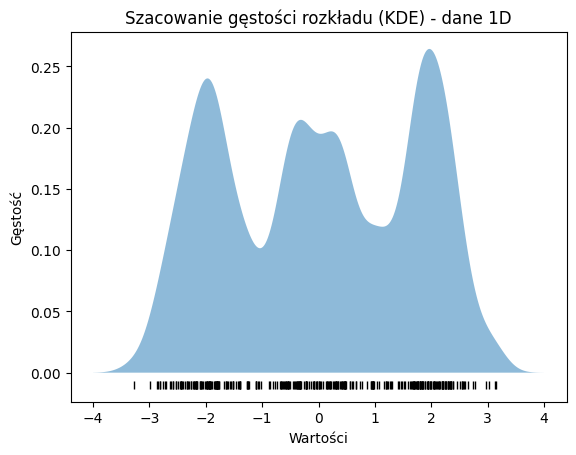

Najlepsze hiperparametry (2D): {'bandwidth': 0.9526315789473684, 'kernel': 'epanechnikov'}


c:\Studia_repo_uczenie_maszynowe\env\lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [-282.0756377           -inf          -inf -225.00393437          -inf
          -inf -207.95782431          -inf          -inf -201.47932698
          -inf          -inf -198.80395791          -inf          -inf
 -197.86060222          -inf          -inf -197.89912438          -inf
          -inf -198.59449854          -inf          -inf -199.77138483
          -inf          -inf -201.31776078          -inf          -inf
 -203.15417692          -inf          -inf -205.21969649          -inf
          -inf -207.46436722          -inf          -inf -209.84524382
          -inf          -inf -212.32449287          -inf          -inf
 -214.86858741 -198.75816649 -198.66286162 -217.44797366 -198.45962246
 -198.09498168 -220.03689132 -198.98797154 -197.79723794 -222.6132146
 -199.54158489 -197.72928918 -225.15827292 -200.40570334 -197.85

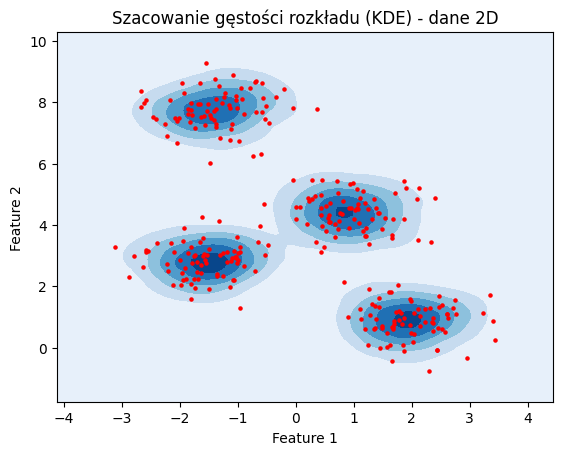

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs

# Szacowanie gęstości rozkładu w 1D
def kde_1d():
    # Generowanie danych 1D za pomocą make_blobs
    X, _ = make_blobs(n_samples=300, centers=[[-2], [0], [2]], cluster_std=0.5, random_state=0)

    # Definicja siatki hiperparametrów
    param_grid = {
        'bandwidth': np.linspace(0.1, 1.0, 20),  # Zmniejszenie liczby punktów w siatce
    }

    # Tworzenie modelu KDE
    kde = KernelDensity()

    # Dopasowanie modelu GridSearchCV do znalezienia najlepszych hiperparametrów
    grid_search = GridSearchCV(kde, param_grid, cv=5)
    grid_search.fit(X)

    # Najlepsze hiperparametry
    best_params = grid_search.best_params_
    print(f"Najlepsze hiperparametry (1D): {best_params}")

    # Dopasowanie modelu KDE z najlepszymi hiperparametrami
    kde = KernelDensity(**best_params)
    kde.fit(X)

    # Generowanie próbek
    X_d = np.linspace(-4, 4, 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_d)

    # Wizualizacja szacowania gęstości
    plt.fill_between(X_d[:, 0], np.exp(log_dens), alpha=0.5)
    plt.plot(X[:, 0], np.full_like(X[:, 0], -0.01), '|k', markeredgewidth=1)
    plt.title("Szacowanie gęstości rozkładu (KDE) - dane 1D")
    plt.xlabel("Wartości")
    plt.ylabel("Gęstość")
    plt.show()

# Szacowanie gęstości rozkładu w 2D
def kde_2d():
    # Generowanie danych 2D
    X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

    # Definicja siatki hiperparametrów
    param_grid = {
        'bandwidth': np.linspace(0.1, 1.0, 20),  # Zmniejszenie liczby punktów w siatce
    }

    # Tworzenie modelu KDE
    kde = KernelDensity()

    # Dopasowanie modelu GridSearchCV do znalezienia najlepszych hiperparametrów
    grid_search = GridSearchCV(kde, param_grid, cv=5)
    grid_search.fit(X)

    # Najlepsze hiperparametry
    best_params = grid_search.best_params_
    print(f"Najlepsze hiperparametry (2D): {best_params}")

    # Dopasowanie modelu KDE z najlepszymi hiperparametrami
    kde = KernelDensity(**best_params)
    kde.fit(X)

    # Generowanie siatki punktów do wizualizacji
    x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_points = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # Obliczanie gęstości na siatce punktów
    log_dens = kde.score_samples(grid_points)
    dens = np.exp(log_dens).reshape(X_grid.shape)

    # Wizualizacja szacowania gęstości
    plt.contourf(X_grid, Y_grid, dens, cmap='Blues')
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5)
    plt.title("Szacowanie gęstości rozkładu (KDE) - dane 2D")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Wykonanie funkcji
kde_1d()
kde_2d()

### Inżynieria cech
Inżynieria cech to proces przekształcania danych w celu poprawy wydajności modeli uczenia maszynowego. Obejmuje to zarówno redukcję wymiarowości (np. metodą PCA), jak i selekcję cech, aby wybrać najbardziej informacyjne cechy.

#### Selekcja cech (różne algorytmy).
Selekcja cech polega na wyborze podzbioru cech, które są najbardziej istotne dla danego problemu predykcyjnego. Można to zrobić na różne sposoby, np. na podstawie znaczenia cech określonego przez model lub poprzez univariate selection, gdzie każda cecha jest oceniana indywidualnie.

In [18]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)
# Dane
data = load_digits()

X = data.data 
y = data.target 

# Trenowanie modelu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tworzenie modelu Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Trening modelu bez selekcji cech
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez selekcji): {accuracy:.4f}")
print("Raport klasyfikacji (bez selekcji):\n", classification_report(y_test, y_pred))

# Selekcja cech na podstawie znaczenia cech
selector = SelectFromModel(rf, prefit=True)
X_train_rf = selector.transform(X_train)
X_test_rf = selector.transform(X_test)

# Trening modelu z selekcją cech (znaczenie cech)
model.fit(X_train_rf, y_train)
y_pred_rf = model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Dokładność na zbiorze testowym (znaczenie cech): {accuracy_rf:.4f}")
print("Raport klasyfikacji (znaczenie cech):\n", classification_report(y_test, y_pred_rf))

# Wybieranie najlepszych cech za pomocą testu ANOVA
selector = SelectKBest(score_func=f_classif, k=2)
X_train_best = selector.fit_transform(X_train, y_train)
X_test_best = selector.transform(X_test)

# Trenowanie modelu po selekcji cech
model.fit(X_train_best, y_train)
y_pred_best = model.predict(X_test_best)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Dokładność na zbiorze testowym (Univariate Selection): {accuracy_best:.4f}")
print("Raport klasyfikacji (Univariate Selection):\n", classification_report(y_test, y_pred_best))

Dokładność na zbiorze testowym (bez selekcji): 0.9722
Raport klasyfikacji (bez selekcji):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.97      0.97        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360

Dokładność na zbiorze testowym (znaczenie cech): 0.9750
Raport klasyfikacji (znaczenie cech):
               precision    recall  f1-score   support



c:\Studia_repo_uczenie_maszynowe\env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Studia_repo_uczenie_maszynowe\env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Redukcja wymiarowości: Metoda PCA

In [16]:
# Wczytywanie danych
data = load_digits()

X = data.data 
y = data.target 

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standaryzacja danych -> każda zmienna ma średnią 0 i wariancję 1 aby zmienne występujące w zbiorze danych były tej samej skali
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Trenowanie modelu bez redukcji wymiarowości
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Dokładność na zbiorze testowym (bez redukcji): {accuracy:.4f}")
print("Raport klasyfikacji (bez redukcji):\n", classification_report(y_test, y_pred))

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model.fit(X_train_pca, y_train)
y_pred_pca = model.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"\nDokładność na zbiorze testowym (PCA): {accuracy_pca:.4f}")
print("Raport klasyfikacji (PCA):\n", classification_report(y_test, y_pred_pca))

Dokładność na zbiorze testowym (bez redukcji): 0.9722
Raport klasyfikacji (bez redukcji):
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.94      0.97        34
           4       0.98      1.00      0.99        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       0.97      0.97      0.97        30
           9       0.95      0.95      0.95        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360


Dokładność na zbiorze testowym (PCA): 0.5389
Raport klasyfikacji (PCA):
               precision    recall  f1-score   support

           0       0.